In [ ]:
# default_exp data.tsdataset

In [ ]:
#hide
%load_ext autoreload
%autoreload 2

## Time Series Dataset
> Transforms pandas DataFrame into a TimeSeriesDataset for the Dataloder.

In [ ]:
#export
import gc
import logging
import random
import time
from collections import defaultdict
from typing import Collection, Dict, Iterable, List, Optional, Tuple
from typing_extensions import Literal

import numpy as np
import pandas as pd
import torch as t
from fastcore.foundation import patch

from torch.utils.data import Dataset, DataLoader

In [ ]:
#export
class TimeSeriesDataset(Dataset):
    """
    A class used to store Time Series data.
    
    Attributes
    ----------
    ts_tensor: np.ndarray
        Numpy array of shape (n_series, n_channels, max_len) 
        where n_channels = t_cols + masks.
        Left-padded time series tensor.
        This tensor is NOT sorted according to Y_df.
        If Y_df is not sorted, the order of the
        first dimension can change.
    s_matrix: np.ndarray
        Numpy array of shape (n_series, n_s).
        Matrix of static variables.
    meta_data: list
        List of meta data. Each element of the list is a 
        numpy array of shape (lenght of the time series, 2) 
        and corresponds to unique_id, ds.
    n_series: int
        Number of time series.
    len_series: list
        List of length of each time series.
    max_len: int
        Length of the longest time series.
    n_x: int
        Number of exogenous time series
        (exogenous variables).
    n_s: int
        Number of static variables.
    n_channels: int
        Number of temporal variables (including target 
        and mask variables). 
    frequency: str
        Infered frequency using pd.infer_freq
        over the ds column from the DataFrame.
    t_cols: list
        List of temporal variables (mask variables included).
    f_cols: list
        List of exogenous variables of the future.
    s_cols:
        List of static variables.
    f_idxs: list
        List of idxs of the exogenous 
        variables of the future.
    
    Methods
    -------
    get_filtered_ts_tensor(output_size, 
                           window_sampling_limit, 
                           ts_idxs)
        Gets ts tensor filtered based on output_size, window_sampling_limit and
        ts_idxs.
    get_f_idxs(cols)
        Gets indexes of exogenous variables.
    """
    
    def __init__(self,
                 Y_df: pd.DataFrame,
                 X_df: pd.DataFrame = None,
                 S_df: pd.DataFrame = None,
                 mask_df: Optional[pd.DataFrame] = None,
                 ds_in_test: int = 0,
                 is_test: bool = False,
                 f_cols: Optional[List] = [],
                 verbose: bool = False) -> 'TimeSeriesDataset':
        """
        Parameters
        ----------
        Y_df: pd.DataFrame
            Target time series with columns ['unique_id', 'ds', 'y'].
        X_df: pd.DataFrame
            Exogenous time series with columns ['unique_id', 'ds', 'y'].
        S_df: pd.DataFrame
            Static exogenous variables with columns ['unique_id', 'ds'] 
            and static variables.
        mask_df: pd.DataFrame
            Outsample mask with columns ['unique_id', 'ds', 'sample_mask']
            and optionally 'available_mask'.
            Default None: constructs default mask based on ds_in_test.
        ds_in_test: int
            Only used when mask_df = None.
            Numer of datestamps to use as outsample.
        is_test: bool
            Only used when mask_df = None.
            Wheter target time series belongs to test set.
        f_cols: list
            List of exogenous variables of the future.
        verbose: bool
            Wheter or not log outputs.
        """
        assert type(Y_df) == pd.core.frame.DataFrame
        assert all([(col in Y_df) for col in ['unique_id', 'ds', 'y']])
        self.verbose = verbose

        if X_df is not None:
            assert type(X_df) == pd.core.frame.DataFrame
            assert all([(col in X_df) for col in ['unique_id', 'ds']])
            assert len(Y_df)==len(X_df), 'The dimensions of Y_df and X_df are not the same'

        if mask_df is not None:
            assert len(Y_df)==len(mask_df), 'The dimensions of Y_df and mask_df are not the same'
            assert all([(col in mask_df) for col in ['unique_id', 'ds', 'sample_mask']])
            if 'available_mask' not in mask_df.columns:
                if self.verbose: 
                    logging.info('Available mask not provided, defaulted with 1s.')
                mask_df['available_mask'] = 1
            assert np.sum(np.isnan(mask_df.available_mask.values)) == 0
            assert np.sum(np.isnan(mask_df.sample_mask.values)) == 0
        else:
            mask_df = get_default_mask_df(Y_df=Y_df, 
                                          is_test=is_test,
                                          ds_in_test=ds_in_test)
        
        n_ds  = len(mask_df)
        n_avl = mask_df.available_mask.sum()        
        n_ins = mask_df.sample_mask.sum()
        n_out = len(mask_df) - mask_df.sample_mask.sum()

        avl_prc = np.round((100 * n_avl) / n_ds, 2)
        ins_prc = np.round((100 * n_ins) / n_ds, 2)
        out_prc = np.round((100 * n_out) / n_ds, 2)
        if self.verbose:
            logging.info('Train Validation splits\n')
            if len(mask_df.unique_id.unique()) < 10:
                logging.info(mask_df.groupby(['unique_id', 'sample_mask']).agg({'ds': ['min', 'max']}))
            else:
                logging.info(mask_df.groupby(['sample_mask']).agg({'ds': ['min', 'max']}))
            dataset_info  = f'\nTotal data \t\t\t{n_ds} time stamps \n'
            dataset_info += f'Available percentage={avl_prc}, \t{n_avl} time stamps \n'
            dataset_info += f'Insample  percentage={ins_prc}, \t{n_ins} time stamps \n'
            dataset_info += f'Outsample percentage={out_prc}, \t{n_out} time stamps \n'
            logging.info(dataset_info)
 
        self.ts_data, self.s_data, self.meta_data, self.t_cols, self.s_cols \
                         = self._df_to_lists(Y_df=Y_df, S_df=S_df, X_df=X_df, mask_df=mask_df)

        # Dataset attributes
        self.n_series = len(self.ts_data)
        self.max_len = max([len(ts) for ts in self.ts_data])
        self.n_channels = len(self.t_cols) # t_cols insample_mask and outsample_mask
        self.frequency = pd.infer_freq(Y_df.head()['ds'])
        self.f_cols = f_cols
        self.f_idxs = self.get_f_idxs(f_cols)

        # Number of X and S features
        self.n_x = 0 if X_df is None else X_df.shape[1] - 2 # -2 for unique_id and ds
        self.n_s = 0 if S_df is None else S_df.shape[1] - 1 # -1 for unique_id

        # Balances panel and creates 
        # numpy  s_matrix of shape (n_series, n_s)
        # numpy ts_tensor of shape (n_series, n_channels, max_len) n_channels = t_cols + masks
        self.ts_tensor, self.s_matrix, self.len_series = self._create_tensor(self.ts_data, self.s_data)

In [ ]:
#export
@patch
def _df_to_lists(self: TimeSeriesDataset, 
                 S_df: pd.DataFrame,
                 Y_df: pd.DataFrame,
                 X_df: pd.DataFrame, 
                 mask_df: pd.DataFrame) -> Tuple[List[np.ndarray], 
                                                 List[np.ndarray],
                                                 List[np.ndarray], 
                                                 List[str],
                                                 List[str]]:
    """Transforms input dataframes to lists.

    Parameters
    ----------
    S_df: pd.DataFrame
        Static exogenous variables with columns ['unique_id', 'ds'] 
        and static variables.    
    Y_df: pd.DataFrame
        Target time series with columns ['unique_id', 'ds', 'y'].
    X_df: pd.DataFrame
        Exogenous time series with columns ['unique_id', 'ds', 'y'].
    mask_df: pd.DataFrame
        Outsample mask with columns ['unique_id', 'ds', 'sample_mask']
        and optionally 'available_mask'.
        Default None: constructs default mask based on ds_in_test.

    Returns
    -------
    Tuple of five lists:
        - List of time series. Each element of the list is a 
          numpy array of shape (length of the time series, n_channels),
          where n_channels = t_cols + masks.
        - List of static variables. Each element of the list is a 
          numpy array of shape (1, n_s).
          where n_channels = t_cols + masks.
        - List of meta data. Each element of the list is a 
          numpy array of shape (lenght of the time series, 2) 
          and corresponds to unique_id, ds.
        - List of temporal variables (including target and masks). 
        - List of statitc variables.
    """
    # None protections
    if X_df is None:
        X_df = Y_df[['unique_id', 'ds']]
    
    if S_df is None:
        S_df = Y_df[['unique_id']].drop_duplicates()
    
    # Protect order of data
    Y = Y_df.sort_values(by=['unique_id', 'ds'], ignore_index=True).copy()
    X = X_df.sort_values(by=['unique_id', 'ds'], ignore_index=True).copy()
    M = mask_df.sort_values(by=['unique_id', 'ds'], ignore_index=True).copy()
    
    assert np.array_equal(X.unique_id.values, Y.unique_id.values), f'Mismatch in X, Y unique_ids'
    assert np.array_equal(X.ds.values, Y.ds.values), f'Mismatch in X, Y ds'
    assert np.array_equal(M.unique_id.values, Y.unique_id.values), f'Mismatch in M, Y unique_ids'
    assert np.array_equal(M.ds.values, Y.ds.values), f'Mismatch in M, Y ds'
    
    # Create bigger grouped by dataframe G to parse
    M = M[['available_mask', 'sample_mask']]
    X.drop(['unique_id', 'ds'], 1, inplace=True)
    G = Y.join(X).join(M)
    
    S = S_df.sort_values(by=['unique_id']).copy()
    
    # time columns and static columns for future indexing
    t_cols = list(G.columns[2:]) # avoid unique_id and ds
    s_cols = list(S.columns[1:]) # avoid unique_id
    
    G = G.groupby(['unique_id'])
    S = S.groupby(['unique_id'])
    
    ts_data = []
    meta_data = []
    for idx, group in G:
        group = group.reset_index(drop=True)
        meta_data.append(group.values[:, :2]) # save unique_id and ds
        ts_data.append(group.values[:, 2:]) # avoid unique_id and ds
        
    s_data = []
    for idx, group in S:
        s_data.append(group.iloc[:, 1:].values) # avoid unique_id
        assert len(s_data[-1])==1, 'Check repetitions of unique_ids'
    
    del S, Y, X, M, G
    gc.collect()
    
    return ts_data, s_data, meta_data, t_cols, s_cols

In [ ]:
# export
@patch
def _create_tensor(self: TimeSeriesDataset, 
                   ts_data: List[Dict[str, np.ndarray]], 
                   s_data: List[Dict[str, np.ndarray]]) -> Tuple[np.ndarray, 
                                                                 np.ndarray,
                                                                 np.ndarray]:
    """Transforms outputs from self._df_to_lists to numpy arrays.

    Parameters
    ----------
    ts_data: List[Dict[str, np.ndarray]]
        Each element of the list is a dictionary with target, exogenous
        and mask values.
    s_data: List[Dict[str, np.ndarray]]
        Each element of the list is a dictionary with static variables.

    Returns
    -------
    Tuple of three elements:
        - ts_tensor of shape (n_series, n_channels, max_len) n_channels = t_cols + masks
        - s_matrix of shape (n_series, n_s)
        - len_series: numpy array with series lenghts.
    """
    ts_tensor = np.zeros((self.n_series, self.n_channels, self.max_len))

    len_series = []
    for idx in range(self.n_series):
        # Left padded time series tensor
        ts_idx = ts_data[idx]
        ts_tensor[idx, :, -ts_idx.shape[0]:] = ts_idx.T
        len_series.append(ts_idx.shape[0])
    
    s_matrix = np.vstack(s_data)
    len_series = np.array(len_series)
    
    return ts_tensor, s_matrix, len_series

In [ ]:
#export
@patch
def get_filtered_ts_tensor(self: TimeSeriesDataset, 
                           window_sampling_limit: int, 
                           ts_idxs: Optional[Collection[int]] = None,
                           output_size: int = 0) -> Tuple[t.Tensor, int]:
    """Filters the last window_sampling_limit observations from ts_tensor for
    the time series indexed by ts_idxs. The output_size
    parameter is returned as the right_padding.

    Parameters
    ----------
    window_sampling_limit: int
        Max size of observations to consider, including output_size.
        If window_sampling_limit > max_len of the time series,
        the full tensor is returned.
    ts_idxs: Collection
        Indexes of time series to consider.
        Default None: returns all ts.
    output_size: int
        Forecast horizon default 0.

    Returns
    -------
    Tuple of filtered tensor and right_padding size (output_size).
    """
    first_ds = max(self.max_len - window_sampling_limit, 0)

    idxs = range(self.n_series) if ts_idxs is None else ts_idxs
    filtered_ts_tensor = self.ts_tensor[idxs, :, first_ds:]
    right_padding = output_size #To padd with zeros if there is "nothing" to the right

    return filtered_ts_tensor, right_padding

In [ ]:
#export
@patch
def get_f_idxs(self: TimeSeriesDataset, 
               cols: List[str]) -> List:
    """Gets indexes of exogenous variables.

    Parameters
    ----------
    cols: List[str]
        Interest exogenous variables.

    Returns
    -------
    Indexes of cols variables.
    """
    # Check if cols are available f_cols and return the idxs
    if not all(col in self.f_cols for col in cols):
        str_cols = ', '.join(cols)
        raise Exception(f'Some variables in {str_cols} are not available in f_cols.')
    
    f_idxs = [self.t_cols.index(col) for col in cols]

    return f_idxs

In [ ]:
#export
def get_default_mask_df(Y_df: pd.DataFrame, 
                        ds_in_test: int, 
                        is_test: bool) -> pd.DataFrame:
    """Constructs default mask df.

    Parameters
    ----------
    Y_df: pd.DataFrame
        Target time series with columns ['unique_id', 'ds', 'y'].
    ds_in_test: int
        Numer of datestamps to use as outsample.
    is_test: bool
        Wheter target time series belongs to test set.

    Returns
    -------
    Mask DataFrame with columns 
    ['unique_id', 'ds', 'available_mask', 'sample_mask'].
    """
    mask_df = Y_df[['unique_id', 'ds']].copy()
    mask_df['available_mask'] = 1
    mask_df['sample_mask'] = 1
    
    mask_df_s = mask_df.sort_values(by=['unique_id', 'ds'])
    zero_idx = mask_df_s.groupby('unique_id').tail(ds_in_test).index
    mask_df.loc[zero_idx, 'sample_mask'] = 0

    assert len(mask_df)==len(Y_df), \
        f'The mask_df length {len(mask_df)} is not equal to Y_df length {len(Y_df)}'

    if is_test:
        mask_df['sample_mask'] = 1 - mask_df['sample_mask']

    return mask_df

# Default mask example and tests

In [ ]:
def test_default_mask(Y_df, ds_in_test, is_test):
    mask_df = get_default_mask_df(Y_df, ds_in_test, is_test)
    assert Y_df.index.equals(mask_df.index), 'Unmatching index bewteen Y_df and mask_df'
    
    for uid, df in mask_df.groupby('unique_id'):
        len_ts = df.shape[0]
        expected_sample_mask = np.ones(len_ts)
        expected_sample_mask[-ds_in_test:] = 0
        if is_test: 
            expected_sample_mask = 1 - expected_sample_mask
        expected_available_mask = np.ones(len_ts)
        
        sample_mask = df['sample_mask'].values
        available_mask = df['available_mask'].values
        
        assert np.array_equal(sample_mask, expected_sample_mask), (
            f'Error for sample mask for time series {uid}'
        )
        
        assert np.array_equal(available_mask, expected_available_mask), (
            f'Error for available mask for time series {uid}'
        )

### Example and test for datasets with two time series

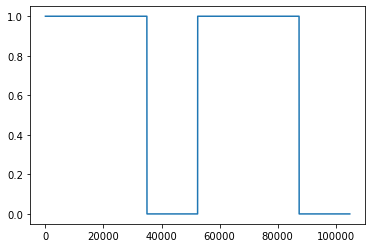

In [ ]:
import matplotlib.pyplot as plt

from nixtla.data.datasets.epf import EPF, EPFInfo

Y_df, X_df, S_df = EPF.load_groups(directory='./data', groups=['NP', 'PJM'])
test_default_mask(Y_df, ds_in_test=728 * 24, is_test=False)
mask_df = get_default_mask_df(Y_df=Y_df, ds_in_test=728 * 24, is_test=False)

plt.plot(mask_df.sample_mask.values)

### Test for datasets with more than two time series

In [ ]:
from nixtla.data.datasets.tourism import Tourism, TourismInfo

meta = TourismInfo['Yearly']
Y_df, *_ = Tourism.load(directory='data', group=meta.name)
test_default_mask(Y_df, ds_in_test=meta.horizon, is_test=False)
test_default_mask(Y_df, ds_in_test=meta.horizon, is_test=True)

## Dataset tests

In [ ]:
def instantiate_dataset(Y_df, S_df, X_df, f_cols, ds_in_test, is_test):
    mask_df = get_default_mask_df(Y_df=Y_df, ds_in_test=ds_in_test, is_test=is_test)
    dataset = TimeSeriesDataset(Y_df=Y_df, S_df=S_df, X_df=X_df, f_cols=f_cols, mask_df=mask_df)
    
    return dataset, mask_df

In [ ]:
def test_dataset_attrs(Y_df, S_df, X_df, f_cols, ds_in_test, is_test):
    dataset, mask_df = instantiate_dataset(Y_df, S_df, X_df, f_cols, ds_in_test, is_test)
    
    dfs = [Y_df, X_df, mask_df]
    dfs = [df.set_index(['unique_id', 'ds']) for df in dfs]
    dfs = dfs[0].join(dfs[1:])
    
    #Temporal variables
    for idx_ts, (uid, df) in enumerate(dfs.groupby('unique_id')):
        len_ts = dataset.len_series[idx_ts]
        
        for col in dataset.t_cols:
            ts = df[col].values
            idx_tensor = dataset.t_cols.index(col)
            ts_tensor = dataset.ts_tensor[idx_ts, idx_tensor, -len_ts:]
            
            assert np.array_equal(ts, ts_tensor), f'Error with time series {uid} and col {col} (idx={idx_ts}).'
            
    #Static variables
    for idx_ts, (uid, df) in enumerate(S_df.groupby('unique_id')):
        len_ts = dataset.len_series[idx_ts]
        
        s = df[dataset.s_cols].values
        s_matrix = dataset.s_matrix[[idx_ts]]

        assert np.array_equal(s, s_matrix), f'Error with static variables for time series {uid} (idx={idx_ts})'

In [ ]:
def test_get_f_idxs(Y_df, S_df, X_df, f_cols, ds_in_test, is_test, expected_f_idxs):
    dataset, mask_df = instantiate_dataset(Y_df, S_df, X_df, f_cols, ds_in_test, is_test)
    
    assert dataset.get_f_idxs(f_cols) == expected_f_idxs

In [ ]:
def test_get_filtered_ts_tensor(Y_df, S_df, X_df, f_cols, ds_in_test, is_test, 
                                window_samplig_limit, ts_idxs, output_size):
    dataset, mask_df = instantiate_dataset(Y_df, S_df, X_df, f_cols, ds_in_test, is_test)
    
    min_len = min(dataset.len_series)
    if window_samplig_limit > min_len:
        raise Exception('This test only works for window_sampling_limit '
                        'lower than the size of the shortest time series.')
    
    dfs = [Y_df, X_df, mask_df]
    dfs = [df.set_index(['unique_id', 'ds']) for df in dfs]
    dfs = dfs[0].join(dfs[1:])
    dfs = dfs.groupby('unique_id').tail(window_samplig_limit)

    n_ts = Y_df['unique_id'].unique().shape[0]
    n_x = dfs.columns.shape[0]
    wsl = window_samplig_limit
    idxs = range(n_ts) if ts_idxs is None else ts_idxs

    e_filtered_tensor = dfs.values.reshape((n_ts, wsl, n_x))[idxs]
    e_filtered_tensor = np.swapaxes(e_filtered_tensor, 2, 1)
    filtered_tensor, rp = dataset.get_filtered_ts_tensor(window_samplig_limit, ts_idxs, output_size)
    
    assert np.array_equal(e_filtered_tensor, filtered_tensor), (
        "Expected and dataset filtered_tensor are different. Check."
    )
    
    assert output_size == rp, 'Output size and right padding are different. Check.'

### Test for already sorted datasets

In [ ]:
from nixtla.data.datasets.epf import EPF, EPFInfo

Y_df, X_df, S_df = EPF.load_groups(directory='./data', groups=['NP', 'PJM'])
f_cols = ['Exogenous1', 'Exogenous2']
ds_in_test = 728 * 24
is_test = True
expected_f_idxs = [1, 2] #after y column

In [ ]:
test_dataset_attrs(Y_df, S_df, X_df, f_cols=f_cols, ds_in_test=ds_in_test, is_test=is_test)

In [ ]:
test_get_filtered_ts_tensor(Y_df, S_df, X_df, f_cols=f_cols, ds_in_test=ds_in_test, is_test=is_test,
                            window_samplig_limit=2_000, ts_idxs=[1, 0], 
                            output_size=ds_in_test)

In [ ]:
test_get_f_idxs(Y_df, S_df, X_df, f_cols=f_cols, ds_in_test=ds_in_test, is_test=is_test, 
                expected_f_idxs=expected_f_idxs)

### Test for datasets with more than two time series

In [ ]:
from nixtla.data.datasets.tourism import Tourism, TourismInfo

meta = TourismInfo['Yearly']
df, *_ = Tourism.load(directory='data', group=meta.name)
df['day_of_week'] = df['ds'].dt.day_of_week
df['id_ts'] = df['unique_id'].astype('category').cat.codes

Y_df = df.filter(items=['unique_id', 'ds', 'y'])
X_df = df.filter(items=['unique_id', 'ds', 'day_of_week'])
S_df = df.filter(items=['unique_id', 'id_ts']).drop_duplicates().reset_index(drop=True)

In [ ]:
test_dataset_attrs(Y_df, S_df, X_df, f_cols=[], ds_in_test=meta.horizon, is_test=True)

In [ ]:
test_get_filtered_ts_tensor(Y_df, S_df, X_df, f_cols=[], ds_in_test=meta.horizon, is_test=False,
                            window_samplig_limit=10, ts_idxs=[1, 7, 10, 15], output_size=meta.horizon)